学習がうまくいったのかどうかを確かめる

1. 予測誤差（全ての時刻における二乗誤差の平均）がinnovationの分散より小さけれな良い

$\sqrt{\mathbb{E}[(\hat X_t-X_t)^2]}$  と  $\sigma^{\ast}$の大小

2. というより普通にinnovationを予測できていればいいのでは？

3. 一応正規性とか独立性も確認して、できていなかったとしてもどこができていないのかを見るべき。でないと正則化の係数を変えられない

In [57]:
%matplotlib inline
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde
import plotly

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [21]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

まずはチェック用のデータを取得

$p^{\ast}=7$, $\phi^{\ast}=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\mu^{\ast}=0$, $\sigma^{\ast}=2$, $_{test}T=1000$<br>
に従うARモデルから生成されるデータ

In [22]:
phi_ast=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p_ast=len(phi_ast)
mu_ast=0
sigma_ast=2

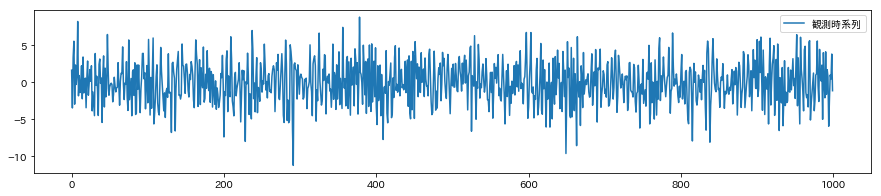

In [23]:
# まずはある時系列を作る（訓練データと生成モデルは同じ）
seed=2**32 - 1
testT=1000
testData = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
plt.figure(figsize=(15,3))
plt.plot(testData, label="観測時系列")
plt.legend()

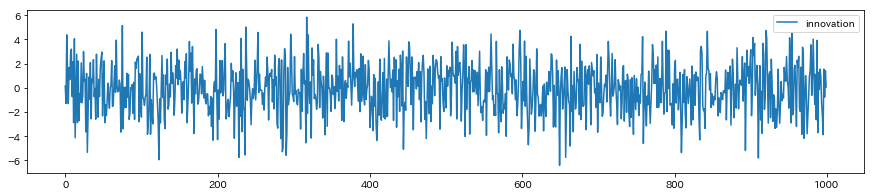

In [24]:
eps = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast, return_innovation=True)
plt.figure(figsize=(15,3))
plt.plot(eps, label="innovation")
plt.legend()

## $p=7$の場合

In [25]:
hat_p=7

## まずは予測誤差がそれなりに小さくなっているかどうかを確かめる。

まずは推定モデルを読み込む

In [10]:
! ls parameters/p7/No6*

parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed0.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed10.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed11.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed12.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed13.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed14.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed15.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed16.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed17.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed18.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed19.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_GP1_Corr0_DataSeed1.pth
parameters/p7/No6_discriminator_epoch1000_batchSize64_

In [8]:
parameter_path = "parameters/p{0}/No6_predictor_epoch0_batchSize64_DataSeed0.pth".format(hat_p)
# parameter_path = "parameters/p{0}/predictor_epoch2000_batchSize64_GP1_Corr1_DataSeed0.pth".format(hat_p)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/No6_predictor_epoch0_batchSize64_DataSeed0.pth


<All keys matched successfully>

### そしたら$F_{\phi}$のパラメータを確認

#### まずはpretrainの結果を見る

In [9]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)

0
0.002174396999180317
2
0.17711874842643738
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.385, -1.014, 0.625, -0.597, 0.661, -0.298, 0.667]


#### 次にGANの学習まで行った後の場合

In [14]:
epoch=2000
parameter_path = "parameters/p{0}/No6_generator_epoch{1}_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_discriminator_epoch{1}_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=64)
discriminator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_predictor_epoch{1}_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/No6_predictor_epoch2000_batchSize64_GP1_Corr0_DataSeed0.pth


<All keys matched successfully>

$F_{\phi}$のパラメータは？

In [15]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)

0
-0.012654398567974567
2
1.0007681846618652
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.373, -1.009, 0.597, -0.609, 0.679, -0.32, 0.655]


### GANの学習をflossの値が最小のところで止めた場合

In [16]:
epoch=2000
parameter_path = "parameters/p{0}/No6_generator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_discriminator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=64)
discriminator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_predictor_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/No6_predictor_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth


<All keys matched successfully>

In [17]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)

0
-0.008678808808326721
2
1.0101759433746338
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.391, -1.015, 0.614, -0.59, 0.679, -0.296, 0.672]


In [26]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[0.1248, 0.1784, 0.0977, 0.3359, 0.2124, 0.2894, 0.0955, 0.3131]]))])

## それぞれのdataSeedに対して普遍性と有効性を確認する

In [89]:
hat_p=7
data_seed = 0#0~21
eps_distribution=[]

In [79]:
parameter_path = "parameters/p{0}/No6_generator_minLoss_batchSize64_GP1_Corr0_DataSeed{1}.pth".format(hat_p, data_seed)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [80]:
X = torch.cat( [torch.tensor(testData[i-hat_p:i+1], dtype=torch.float).view(1, hat_p+1) for i in range(hat_p, len(testData)-1)]).view(-1,1,hat_p+1)#torch.Size([992, 1, 8])
hat_eps = np.array(generator(X).view(-1).detach())

In [ ]:
eps_distribution.append(hat_eps)

In [111]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(hat_p, len(hat_eps))), y=eps[hat_p:], name="真のinno", yaxis='y'),
        plotly.graph_objs.Scatter(x=list(range(hat_p, len(hat_eps))), y=hat_eps, name="推定inno", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="テストデータにおけるinnovation推定量の系列と真のinnovationの系列",
                legend={"x":1, "y":1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 1500,       # 全体のサイズ
                height = 500,
                )
)
plotly.offline.iplot(fig)

In [94]:
hat_p=7
eps_distribution=[]
for data_seed in range(0, 22):
    parameter_path = "parameters/p{0}/No6_generator_minLoss_batchSize64_GP1_Corr0_DataSeed{1}.pth".format(hat_p, data_seed)
    generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
    generator.load_state_dict(torch.load(parameter_path, map_location=torch.device('cpu')))
    X = torch.cat( [torch.tensor(testData[i-hat_p:i+1], dtype=torch.float).view(1, hat_p+1) for i in range(hat_p, len(testData)-1)]).view(-1,1,hat_p+1)#torch.Size([992, 1, 8])
    hat_eps = np.array(generator(X).view(-1).detach())
    eps_distribution.append(hat_eps)
eps_distribution=np.array(eps_distribution)

In [107]:
有効性=eps_distribution.std(axis=0)
普遍性=np.sqrt(((eps_distribution-eps[hat_p:-1])**2).mean(axis=0))

In [110]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(len(testData))), y=testData, name="観測時系列", yaxis='y'),
        plotly.graph_objs.Scatter(x=list(range(hat_p,len(testData))), y=普遍性, name="普遍性", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(hat_p,len(testData))), y=有効性, name="有効性", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="テストデータにおけるinnovation推定量の普遍性と有効性の遷移",
                legend={"x":1, "y":1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 1500,       # 全体のサイズ
                height = 500,
                )
)
plotly.offline.iplot(fig)
print(普遍性.mean())
print(有効性.mean())

1.6735432951341134
0.89783466


In [60]:
! ls ../withoutDiscriminator/parameters/p7/

No0_3_predictor_epoch0_batchSize64_DataSeed0.pth
No0_generator_epoch10_batchSize64_DataSeed0.pth
No0_generator_epoch10_batchSize64_GP1_Corr0_DataSeed0.pth
No0_generator_epoch1_batchSize64_DataSeed0.pth
No0_generator_minLoss_batchSize64_DataSeed0.pth
No0_generator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth
No0_predictor_epoch0_batchSize64_DataSeed0.pth
No0_predictor_epoch10_batchSize64_DataSeed0.pth
No0_predictor_epoch10_batchSize64_GP1_Corr0_DataSeed0.pth
No0_predictor_epoch1_batchSize64_DataSeed0.pth
No0_predictor_minLoss_batchSize64_DataSeed0.pth
No0_predictor_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth
No1_generator_epoch1000_batchSize64_DataSeed0.pth
No1_generator_epoch100_batchSize64_DataSeed0.pth
No1_generator_epoch200_batchSize64_DataSeed0.pth
No1_generator_epoch300_batchSize64_DataSeed0.pth
No1_generator_epoch400_batchSize64_DataSeed0.pth
No1_generator_epoch500_batchSize64_DataSeed0.pth
No1_generator_epoch600_batchSize64_DataSeed0.pth
No1_generator_epoch700_batchSize64_DataSee

In [115]:
hat_p=7
data_seed = 0

In [116]:
parameter_path = "../withoutDiscriminator/parameters/p{0}/No2_generator_mingLoss_batchSize64_DataSeed{1}.pth".format(hat_p, data_seed)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [117]:
X = torch.cat( [torch.tensor(testData[i-hat_p:i+1], dtype=torch.float).view(1, hat_p+1) for i in range(hat_p, len(testData)-1)]).view(-1,1,hat_p+1)#torch.Size([992, 1, 8])
hat_eps = np.array(generator(X).view(-1).detach())

In [118]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(hat_p, len(hat_eps))), y=eps[hat_p:], name="真のinno", yaxis='y'),
        plotly.graph_objs.Scatter(x=list(range(hat_p, len(hat_eps))), y=hat_eps, name="推定inno", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="テストデータにおけるinnovation推定量の系列と真のinnovationの系列",
                legend={"x":1, "y":1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 1500,       # 全体のサイズ
                height = 500,
                )
)
plotly.offline.iplot(fig)